<a name='1'></a>
## Import Packages and load data

In [1]:
### -*- coding: utf-8 -*-
"""
Created on Mon May 24 13:26:13 2021

@author: kjsanche

Description: 
A function to load the 5 minute granules from MODIS channel 1 
(0.65 microns) and the contrail mask for ML with a CNN.

To do:
ASAP:
-create blacklist of images to exclude (if images are to big)
-separate testing data
-plot testing data vs mask



lower priority:
-optimize image shape by transforming back to original satellite swath projection
-save and set up to load data as tfrecord
-organize/markdown/comment code


Input:
Path   (string)

        
        
Output:
MODISCh1 (2D uint32)
MASK     (2D uint16)
"""


from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import struct
import os
import glob
from UNET_Functions import unet_model, summary
from Sat_contrail_read import Extract_RawDef, extract_img, extract_mask, extract_imglist, get_model_memory_usage
import tensorflow as tf

sys_details = tf.sysconfig.get_build_info()
print(sys_details)
cudnn_version = sys_details["cudnn_version"]
cuda_version = sys_details["cuda_version"]

print('cuda version: ', cuda_version)
print('cudNN version: ',cudnn_version)
print('TF version: ', tf.version.VERSION)



#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.experimental.output_all_intermediates(True) 
path = os.getcwd()
proj_path = os.path.normpath(path + os.sep + os.pardir) #get parent directory
image_path = '/home/kjsanche/Desktop/ExternalSSD/SatContrailData' #os.path.join(proj_path, 'data/')



image0065, image0380, image0680, image0850, image1100, image1200, image1330, AUX_list, mask_list = extract_imglist(image_path)

N = len(image0065)
print(N)

OrderedDict([('cpu_compiler', '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614583966145/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'), ('cuda_compute_capabilities', ['compute_35', 'compute_52', 'compute_60', 'compute_61', 'compute_70', 'compute_75']), ('cuda_version', '10.1'), ('cudnn_version', '7'), ('is_cuda_build', True), ('is_rocm_build', False)])
cuda version:  10.1
cudNN version:  7
TF version:  2.4.1
5924


## extract image dimensions

In [2]:
dim = Extract_RawDef(AUX_list)

## make dataset

In [4]:
img0065_filenames = tf.constant(image0065)
img0380_filenames = tf.constant(image0380)
img0680_filenames = tf.constant(image0680)
img0850_filenames = tf.constant(image0850)
img1100_filenames = tf.constant(image1100)
img1200_filenames = tf.constant(image1200)
img1330_filenames = tf.constant(image1330)

masks_filenames = tf.constant(mask_list)
print(img1100_filenames.shape)
print(masks_filenames.shape)
dataset = tf.data.Dataset.from_tensor_slices((img0065_filenames, img0380_filenames, img0680_filenames, img0850_filenames, img1100_filenames, img1200_filenames, img1330_filenames, masks_filenames, dim))
#print(dataset)

(5924,)
(5924,)


In [5]:
def process_path(img0065_path, img0380_path, img0680_path, img0850_path, img1100_path, img1200_path, img1330_path, mask_path,dim):
# convert binary files to matrix of integers

    img1 = extract_img(str(img0065_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img2 = extract_img(str(img0380_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img3 = extract_img(str(img0680_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img4 = extract_img(str(img0850_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img5 = extract_img(str(img1100_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img6 = extract_img(str(img1200_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
    img7 = extract_img(str(img1330_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))

    img = np.concatenate((img1, img2, img3, img4, img5, img6, img7), axis=2)
    
    mask = extract_mask(str(mask_path.numpy().decode('ascii')),int(dim[0].numpy()),int(dim[1].numpy()))
   
    return tf.convert_to_tensor(img,dtype=tf.float16), tf.convert_to_tensor(mask,dtype=tf.int8)

def preprocess(image, mask):
    input_image = tf.image.resize(image, (2048, 4096), method='nearest')
    #print(img)
    input_mask = tf.image.resize(mask, (2048, 4096), method='nearest')
    #input_image(input_image>0) = 1
    input_image = (input_image-25500) / np.float16(7500) # assuming range of 180-330 K (BT is multiplied by 100)

    return input_image, input_mask

def _set_shapes(img, mask):
    img.set_shape([4096, 4096, 7])
    mask.set_shape([4096, 4096, 1])

    return img, mask 

#print(dataset)
image_ds = dataset.map(lambda aa, bb, cc, dd, ee, ff, gg, hh, ii: tf.py_function(process_path, [aa, bb, cc, dd, ee, ff, gg, hh, ii], [tf.float16, tf.int8]))
image_ds = image_ds.map(_set_shapes)
print(image_ds)
processed_image_ds = image_ds.map(preprocess)

print(processed_image_ds)

<MapDataset shapes: ((4096, 4096, 7), (4096, 4096, 1)), types: (tf.float16, tf.int8)>
<MapDataset shapes: ((2048, 4096, 7), (2048, 4096, 1)), types: (tf.float16, tf.int8)>


In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        print(i)
        print(display_list[i].shape)
        if i == 0:
            plt.imshow(np.float32(display_list[i][:,:,0]-display_list[i][:,:,1]))
        else:
            plt.imshow(np.float32(1*display_list[i]))
        plt.axis('off')
    plt.show()

The below code cell uses a lot of memory and therefore should not be used during training.

0
(4096, 4096, 7)
1
(4096, 4096, 1)


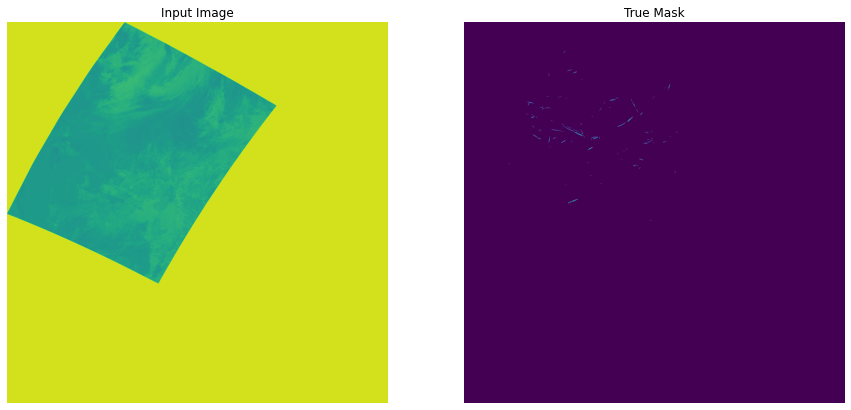

mem usage:  251660032


In [7]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    #print(mask.shape)
display([sample_image, sample_mask])
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

## extract all images for each wavelength

## extract all masks

## resize all data to be smaller

In [6]:
img_height = 2048
img_width = 4096
num_channels = 7

print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

unet = unet_model((img_height, img_width, num_channels))
#unet.summary()
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
unet.summary()
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

mem usage:  0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 4096,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2048, 4096, 3 2048        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2048, 4096, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1024, 2048, 3 0           conv2d_1[0][0]                   
________________________________________________________________________________

In [7]:
EPOCHS = 1


BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = N 
print(get_model_memory_usage(BATCH_SIZE, unet))
#processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.batch(BATCH_SIZE)


#print(train_dataset.shape)

print(processed_image_ds.element_spec)
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))
model_history = unet.fit(train_dataset, epochs=EPOCHS)

15.407
(TensorSpec(shape=(2048, 4096, 7), dtype=tf.float16, name=None), TensorSpec(shape=(2048, 4096, 1), dtype=tf.int8, name=None))
mem usage:  34573568


ResourceExhaustedError:  OOM when allocating tensor with shape[1,256,256,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_transpose/conv2d_transpose (defined at <ipython-input-7-068d320c5344>:15) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2681]

Function call stack:
train_function


In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])